## Prediction Model for WRBTC usage 

In [2]:
# Import packages 
import functions
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_absolute_error
from xgboost import XGBRegressor

### Query and Save Data 

In [3]:
# Load the api key to access the data on footprint analytics 
api_key = functions.load_secret('.env')

if api_key:
    print("API key loaded successfully")
else:
    print("Failed to load API key")

API key loaded successfully


In [4]:
# query the rootstock token data 
wrbtc_trans = functions.query_data(api_key, 49935)
wrbtc_unique_senders = functions.query_data(api_key, 49946)
wrbtc_trans_value = functions.query_data(api_key, 49936)
wrbtc_price = functions.query_data(api_key, 49937)
rbtc_fee = functions.query_data(api_key, 49938)
wrbtc_unique_recipients = functions.query_data(api_key, 49948)

In [5]:
# save data  
# functions.save_df_to_csv(wrbtc_trans, 'wrbtc_trans.csv')
# functions.save_df_to_csv(wrbtc_unique_senders, 'wrbtc_unique_senders.csv')
# functions.save_df_to_csv(wrbtc_trans_value, 'wrbtc_trans_value.csv')
# functions.save_df_to_csv(wrbtc_price, 'wrbtc_price.csv')
# functions.save_df_to_csv(rbtc_fee, 'rbtc_fee.csv')
# functions.save_df_to_csv(wrbtc_unique_recipients , 'wrbtc_unique_recipients.csv')

### Load and Transform Data 

In [6]:
wrbtc_trans = functions.load_csv_to_dataframe('wrbtc_trans.csv')
wrbtc_unique_senders = functions.load_csv_to_dataframe('wrbtc_unique_senders.csv')
wrbtc_trans_value = functions.load_csv_to_dataframe('wrbtc_trans_value.csv')
wrbtc_price = functions.load_csv_to_dataframe('wrbtc_price.csv')
rbtc_fee = functions.load_csv_to_dataframe('rbtc_fee.csv')
wrbtc_unique_recipients = functions.load_csv_to_dataframe('wrbtc_unique_recipients.csv')

DataFrame loaded successfully with 604 rows and 4 columns.
DataFrame loaded successfully with 604 rows and 4 columns.
DataFrame loaded successfully with 604 rows and 4 columns.
DataFrame loaded successfully with 608 rows and 4 columns.
DataFrame loaded successfully with 607 rows and 4 columns.
DataFrame loaded successfully with 604 rows and 4 columns.


In [7]:
# Merge Datasets 
merged_data = wrbtc_price 

suffixes_list = ['_fee', '_trans', '_senders', '_value', '_recipients']

for df, suffix in zip([rbtc_fee, wrbtc_trans, wrbtc_unique_senders, wrbtc_trans_value, wrbtc_unique_recipients], suffixes_list):
    merged_data = pd.merge(merged_data, df, on='timestamp', how='left', suffixes=('', suffix))


In [8]:
add_column_names = ['timestamp', 'price', 'price_30_day', 'price_90_day', 'fee', 'fee_30_day', 'fee_90_day', 'trans', 'trans_30_day', 'trans_90_day', 'senders', 'senders_30_day', 'senders_90_day',
                                 'trans_value', 'trans_value_30_day', 'trans_value_90_day', 'recipients', 'recipients_30_day', 'recipients_90_day']
merged_data.columns = add_column_names
merged_data['timestamp'] = pd.to_datetime(merged_data['timestamp']).dt.normalize()
merged_data.head()

,timestamp,price,price_30_day,price_90_day,fee,fee_30_day,fee_90_day,trans,trans_30_day,trans_90_day,senders,senders_30_day,senders_90_day,trans_value,trans_value_30_day,trans_value_90_day,recipients,recipients_30_day,recipients_90_day
0,2020-10-01 00:00:00+00:00,10765.178365,10765.178365,10765.178365,0.000003,0.000003,0.000003,11.0,11.000000,11.000000,6.0,6.00,6.00,0.126181,0.126181,0.126181,4.0,4.000000,4.000000
1,2020-10-02 00:00:00+00:00,10567.983468,10666.580917,10666.580917,0.000003,0.000003,0.000003,24.0,17.500000,17.500000,4.0,5.00,5.00,0.034885,0.080533,0.080533,3.0,3.500000,3.500000
2,2020-10-03 00:00:00+00:00,10563.080907,10632.080913,10632.080913,0.000003,0.000003,0.000003,11.0,15.333333,15.333333,5.0,5.00,5.00,0.018107,0.059724,0.059724,4.0,3.666667,3.666667
3,2020-10-04 00:00:00+00:00,10588.643469,10621.221552,10621.221552,0.000003,0.000003,0.000003,19.0,16.250000,16.250000,4.0,4.75,4.75,0.034225,0.053349,0.053349,5.0,4.000000,4.000000
4,2020-10-05 00:00:00+00:00,10695.630025,10636.103247,10636.103247,0.000003,0.000003,0.000003,38.0,20.600000,20.600000,5.0,4.80,4.80,0.063417,0.055363,0.055363,3.0,3.800000,3.800000


### Target Variables Visualization 

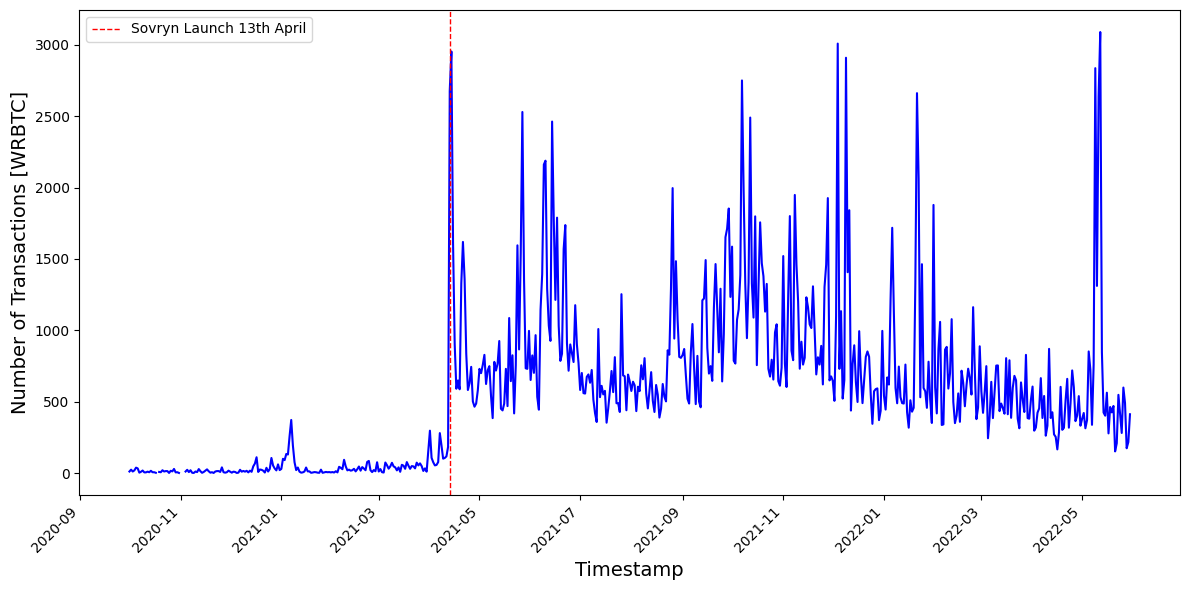

In [9]:
# Number of Daily Transactions 
plt.figure(figsize=(12, 6))
plt.plot(merged_data['timestamp'], merged_data['trans'], linestyle='-', color='b')
plt.xlabel('Timestamp', fontsize=14)
plt.ylabel('Number of Transactions [WRBTC]', fontsize=14)
plt.axvline(pd.to_datetime('2021-04-13'), color='red', linestyle='--', linewidth=1, label='Sovryn Launch 13th April')
plt.legend()
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('plots/transaction_data.png')

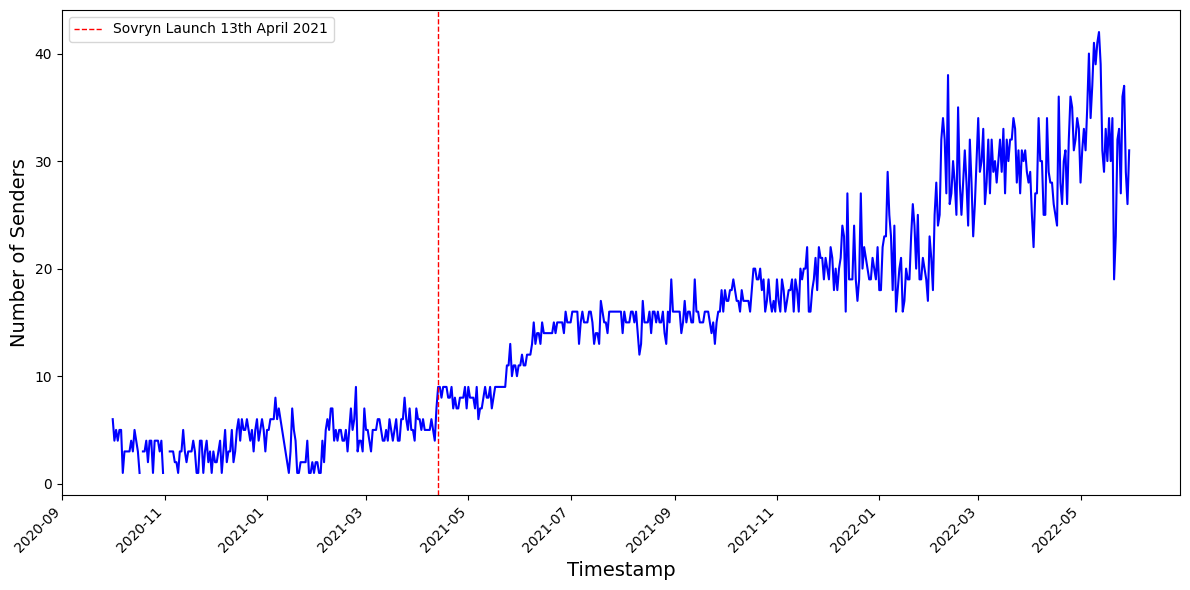

In [10]:
# Number of Active Daily Addresses 
plt.figure(figsize=(12, 6))
plt.plot(merged_data['timestamp'], merged_data['senders'], linestyle='-', color='b')
plt.xlabel('Timestamp', fontsize=14)
plt.ylabel('Number of Senders', fontsize=14)
plt.axvline(pd.to_datetime('2021-04-13'), color='red', linestyle='--', linewidth=1, label='Sovryn Launch 13th April 2021')
plt.legend()
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('plots/senders_data.png')

## Machine Learning Models

### 1. Model to Predict Number of WRBTC transactions 

In [11]:
# Define regressors and target 
regressors = ['price_30_day', 'fee', 'fee_30_day', 'trans_90_day', 'senders', 'senders_90_day',
              'trans_value', 'trans_value_30_day', 'trans_value_90_day', 'recipients', 'recipients_90_day']
target = 'trans'

#### Split data into training and testing data 

In [12]:
split_date = merged_data['timestamp'].quantile(0.8)
test_data = merged_data[merged_data['timestamp'] > split_date]
train_data = merged_data[merged_data['timestamp'] <= split_date]
X_train, y_train = train_data[regressors], train_data[target]
X_test, y_test = test_data[regressors], test_data[target]

split_date

Timestamp('2022-01-29 14:24:00+0000', tz='UTC')

#### Handle missing values in the target variable 

In [13]:
print("NaN values in y_train:", np.isnan(y_train).sum())
print("NaN values in y_test:", np.isnan(y_test).sum())

NaN values in y_train: 3
NaN values in y_test: 1


In [14]:
# Linear Interpolate missing values for both y_train and y_test
y_train_interpolated = (pd.Series(y_train).interpolate(method='linear').bfill().ffill().to_numpy())
y_test_interpolated = (pd.Series(y_test).interpolate(method='linear').bfill().ffill().to_numpy())

#### Grid search to determine best parameters for the ML model

In [15]:
# Search for best model parameters using the training dataset 
param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 6, 9, 12],
    'min_child_weight': [1, 5, 10, 15]
}

grid_search = GridSearchCV(XGBRegressor(), param_grid, cv=3, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train_interpolated)

best_params = grid_search.best_params_
print("Best Parameters:", best_params)

Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 10, 'n_estimators': 100}


#### Train the ML model 

In [16]:
reg = XGBRegressor(
    n_estimators=best_params['n_estimators'],
    learning_rate=best_params['learning_rate'],
    max_depth=best_params['max_depth'],
    min_child_weight=best_params['min_child_weight']
)

# Fit the model with evaluation sets and early stopping
evals = [(X_train, y_train_interpolated), (X_test, y_test_interpolated)]
reg.fit(
    X_train, 
    y_train_interpolated, 
    eval_set=evals
)

[0]	validation_0-rmse:542.35510	validation_1-rmse:408.83841
[1]	validation_0-rmse:501.48462	validation_1-rmse:380.74521
[2]	validation_0-rmse:464.96833	validation_1-rmse:355.16162
[3]	validation_0-rmse:432.56607	validation_1-rmse:334.20884
[4]	validation_0-rmse:402.55553	validation_1-rmse:321.31882
[5]	validation_0-rmse:376.68962	validation_1-rmse:306.19386
[6]	validation_0-rmse:352.49896	validation_1-rmse:291.21712
[7]	validation_0-rmse:331.96411	validation_1-rmse:281.34510
[8]	validation_0-rmse:313.49036	validation_1-rmse:268.52702
[9]	validation_0-rmse:297.78449	validation_1-rmse:257.58898
[10]	validation_0-rmse:283.31624	validation_1-rmse:253.53581
[11]	validation_0-rmse:268.90689	validation_1-rmse:248.23492
[12]	validation_0-rmse:257.85531	validation_1-rmse:247.45316
[13]	validation_0-rmse:246.81371	validation_1-rmse:242.53185
[14]	validation_0-rmse:237.27927	validation_1-rmse:237.22603
[15]	validation_0-rmse:229.29317	validation_1-rmse:235.36290
[16]	validation_0-rmse:222.74044	v

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=10, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

#### Model Prediction 

In [17]:
predictions = reg.predict(X_test)
test_data = test_data.reset_index().drop('index', axis=1)
test_data['predictions'] = pd.Series(predictions)

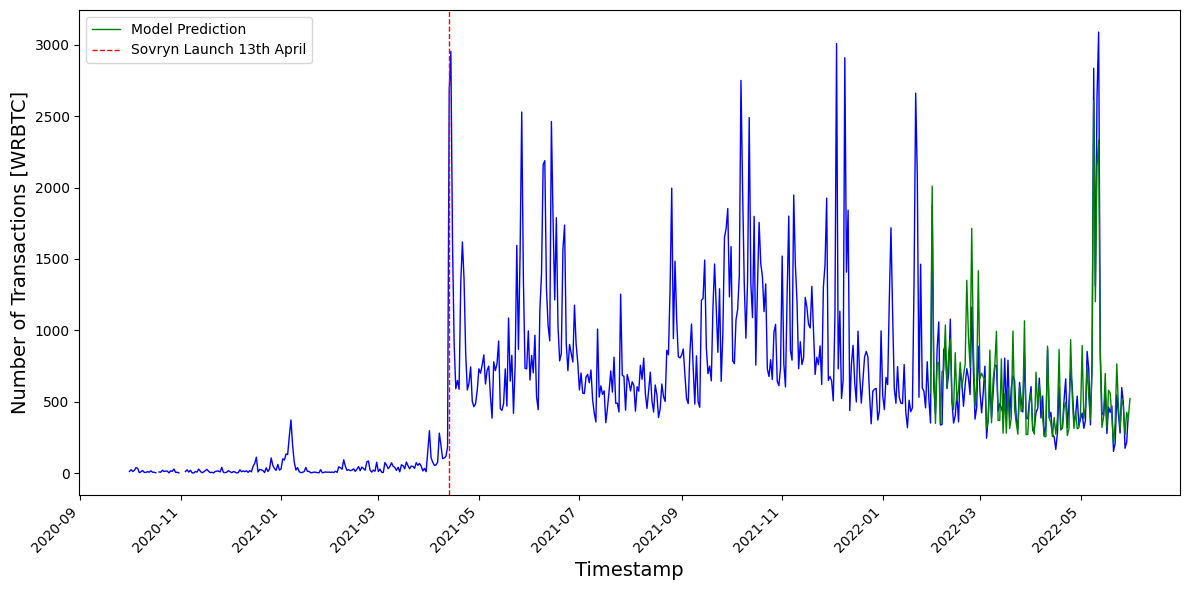

In [18]:
# Prediction of ML model 
plt.figure(figsize=(12, 6))
plt.plot(merged_data['timestamp'], merged_data['trans'], linestyle='-', linewidth=1, color='b')
plt.plot(test_data['timestamp'], test_data['predictions'], linestyle='-', color='g', linewidth=1, label='Model Prediction')
plt.xlabel('Timestamp', fontsize=14)
plt.ylabel('Number of Transactions [WRBTC]', fontsize=14)
plt.axvline(pd.to_datetime('2021-04-13'), color='red', linestyle='--', linewidth=1, label='Sovryn Launch 13th April')
plt.legend()
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('plots/transaction_prediction.png')

#### Correlation analysis of feature importance

In [19]:
importances = reg.feature_importances_

# Create a DataFrame for easy visualization
importances_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

importances_df


,Feature,Importance
6,trans_value,0.484524
2,fee_30_day,0.190629
1,fee,0.078938
4,senders,0.058713
5,senders_90_day,0.040132
8,trans_value_90_day,0.034264
9,recipients,0.029784
10,recipients_90_day,0.028037
7,trans_value_30_day,0.021612
0,price_30_day,0.018728


#### Evaluate Model Predictions 

In [20]:
mae = mean_absolute_error(y_test_interpolated, predictions)
print(f'On average model predictions deviate from the actual values by approximately {round(mae, 2)} units.')

On average model predictions deviate from the actual values by approximately 136.32 units.


In [21]:
r2 = r2_score(y_test_interpolated, predictions)
print(f'Approximately {round(r2*100, 2)}% of the variance in the target variable is explained by the model.')

Approximately 80.79% of the variance in the target variable is explained by the model.


### 2. Model to Predict Number of unique addresses using the WRBTC token 

In [22]:
# Define regressors and target 
regressors = ['price_90_day', 'fee_90_day', 'trans', 'trans_90_day', 'senders_30_day', 'senders_90_day',
              'trans_value', 'trans_value_90_day', 'recipients', 'recipients_30_day', 'recipients_90_day']
target = 'senders'

#### Split data into training and testing data 

In [23]:
split_date = merged_data['timestamp'].quantile(0.7)
test_data = merged_data[merged_data['timestamp'] > split_date]
train_data = merged_data[merged_data['timestamp'] <= split_date]
X_train, y_train = train_data[regressors], train_data[target]
X_test, y_test = test_data[regressors], test_data[target]

split_date

Timestamp('2021-11-29 21:36:00+0000', tz='UTC')

#### Handle missing values in the target variable 

In [24]:
print("NaN values in y_train:", np.isnan(y_train).sum())
print("NaN values in y_test:", np.isnan(y_test).sum())

NaN values in y_train: 3
NaN values in y_test: 1


In [25]:
# Linear Interpolate missing values for both y_train and y_test
y_train_interpolated = (pd.Series(y_train).interpolate(method='linear').bfill().ffill().to_numpy())
y_test_interpolated = (pd.Series(y_test).interpolate(method='linear').bfill().ffill().to_numpy())

#### Grid search to determine best parameters for the ML model

In [26]:
# Search for best model parameters using the training dataset 
param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 6, 9, 12],
    'min_child_weight': [1, 5, 10, 15]
}

grid_search = GridSearchCV(XGBRegressor(), param_grid, cv=3, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train_interpolated)

best_params = grid_search.best_params_
print("Best Parameters:", best_params)

Best Parameters: {'learning_rate': 0.2, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 500}


#### Train the ML model

In [27]:
reg = XGBRegressor(
    n_estimators=best_params['n_estimators'],
    learning_rate=best_params['learning_rate'],
    max_depth=best_params['max_depth'],
    min_child_weight=best_params['min_child_weight']
)

# Fit the model with evaluation sets and early stopping
evals = [(X_train, y_train_interpolated), (X_test, y_test_interpolated)]
reg.fit(
    X_train, 
    y_train_interpolated, 
    eval_set=evals)

[0]	validation_0-rmse:4.81231	validation_1-rmse:16.63108
[1]	validation_0-rmse:3.91498	validation_1-rmse:15.37840
[2]	validation_0-rmse:3.20098	validation_1-rmse:14.29259
[3]	validation_0-rmse:2.63334	validation_1-rmse:13.22063
[4]	validation_0-rmse:2.18624	validation_1-rmse:12.38142
[5]	validation_0-rmse:1.83582	validation_1-rmse:11.72046
[6]	validation_0-rmse:1.56308	validation_1-rmse:11.15519
[7]	validation_0-rmse:1.35359	validation_1-rmse:10.92874
[8]	validation_0-rmse:1.19072	validation_1-rmse:10.73787
[9]	validation_0-rmse:1.07247	validation_1-rmse:10.35751
[10]	validation_0-rmse:0.98282	validation_1-rmse:10.05634
[11]	validation_0-rmse:0.91608	validation_1-rmse:9.96848
[12]	validation_0-rmse:0.86780	validation_1-rmse:9.85012
[13]	validation_0-rmse:0.83260	validation_1-rmse:9.80370
[14]	validation_0-rmse:0.80589	validation_1-rmse:9.78967
[15]	validation_0-rmse:0.78593	validation_1-rmse:9.75893
[16]	validation_0-rmse:0.77051	validation_1-rmse:9.73970
[17]	validation_0-rmse:0.75374

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=5, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

#### Model Prediction

In [28]:
predictions = reg.predict(X_test)
test_data = test_data.reset_index().drop('index', axis=1)
test_data['predictions'] = pd.Series(predictions)

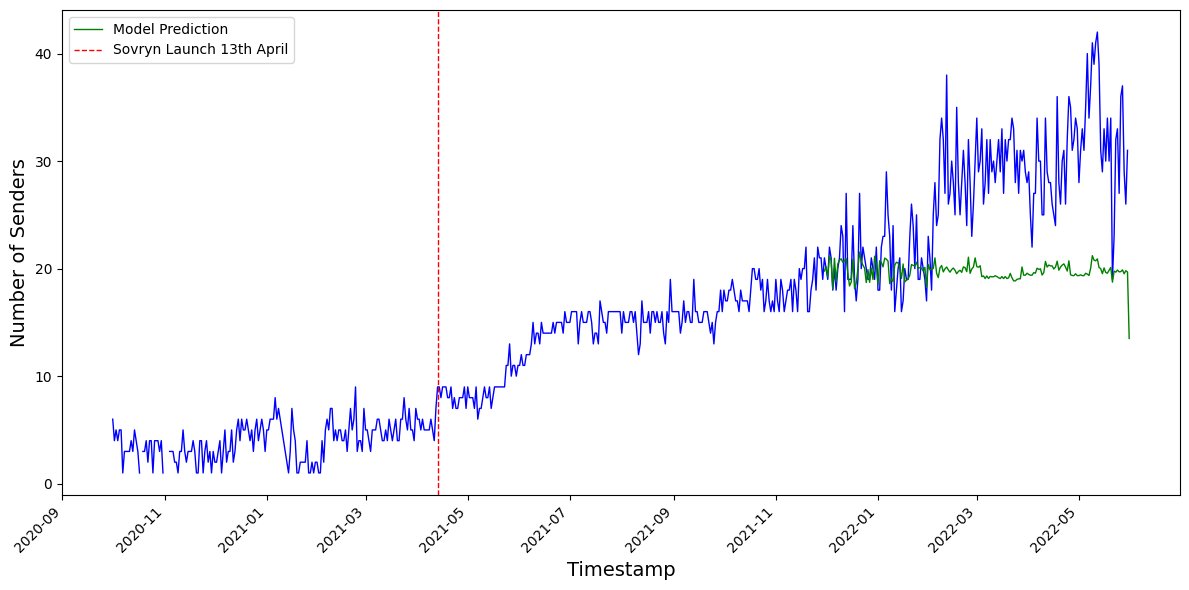

In [29]:
# Prediction of ML model 
plt.figure(figsize=(12, 6))
plt.plot(merged_data['timestamp'], merged_data['senders'], linestyle='-', linewidth=1, color='b')
plt.plot(test_data['timestamp'], test_data['predictions'], linestyle='-', color='g', linewidth=1, label='Model Prediction')
plt.xlabel('Timestamp', fontsize=14)
plt.ylabel('Number of Senders', fontsize=14)
plt.axvline(pd.to_datetime('2021-04-13'), color='red', linestyle='--', linewidth=1, label='Sovryn Launch 13th April')
plt.legend()
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('plots/senders_prediction.png')

#### Correlation analysis of feature importance

In [30]:
importances = reg.feature_importances_

# Create a DataFrame for easy visualization
importances_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

importances_df

,Feature,Importance
1,fee_90_day,0.699474
8,recipients,0.180735
3,trans_90_day,0.043619
2,trans,0.028644
4,senders_30_day,0.013261
5,senders_90_day,0.010313
0,price_90_day,0.006211
9,recipients_30_day,0.006010
6,trans_value,0.005182
10,recipients_90_day,0.003626


#### Ecaluate model Prediction

In [31]:
mae = mean_absolute_error(y_test_interpolated, predictions)
print(f'On average model predictions deviate from the actual values by approximately {round(mae, 2)} units.')

On average model predictions deviate from the actual values by approximately 7.49 units.
